![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics

# Günther-Salzer model -- damage free component

Following:

Günther, R.-M., Salzer, K., Popp, T., & Lüdeling, C. (2015). Steady-State Creep of Rock Salt: Improved Approaches for Lab Determination and Modelling. Rock Mechanics and Rock Engineering, 48(6), 2603–2613. https://doi.org/10.1007/s00603-015-0839-2

Günther, R., & Salzer, K. (2012). Advanced strain-hardening approach. In Mechanical Behaviour of Salt VII (Issue December 2016). CRC Press. https://doi.org/10.1201/b12041-4

\begin{align}
    \dot{\epsilon}_\text{cr} &= \dot{\epsilon}_\text{cr}^\text{V} + \dot{\epsilon}_\text{cr}^\text{E}
    \\
    \dot{\epsilon}_\text{cr} &= A_\text{p} \frac{ (\bar{\sigma}/\sigma_\text{ref})^{n_\text{p}}}{\left( \epsilon^\text{V}_0 + \epsilon_\text{cr}^\text{V} \right)^{\mu_\text{p}}} \quad \text{with} \quad \bar{\sigma} = \sqrt{\frac{3}{2}} \left\lVert \mathbf{s} \right\rVert
    \\
    \dot{\epsilon}_\text{cr}^\text{E} &= \sum \limits_{i=1}^2 A_{\text{s},i} \exp \left( - \frac{Q_i}{RT} \right) \left( \frac{\bar{\sigma}}{\sigma_\text{ref}} \right)^{n_i}
\end{align}

3D:

$$
    \dot{\boldsymbol\epsilon}_\text{cr} = \sqrt{\frac{3}{2}} \dot{\epsilon}_\text{cr} \frac{\mathbf{s}}{\left\lVert \mathbf{s} \right\rVert}
$$

In [1]:
#HIDDEN
import mtest
import numpy as np
import matplotlib.pyplot as plt
import os
import plot_settings
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)

In [2]:
#HIDDEN
build_release = 'mfront --obuild --interface=generic GuentherSalzer.mfront'
#os.system(build_release)

## Analytical solution for constant strain rate (primary creep)

Analytische Lösung unter der Voraussetzung, dass $\dot{\epsilon}_\text{cr}^\text{E} = 0$ und somit $\epsilon_\text{cr} \equiv \epsilon_\text{cr}^\text{V}$:

$$
    \dot{\epsilon}_\text{cr} = A_\text{p} \frac{ (\bar{\sigma}/\sigma_\text{ref})^{n_\text{p}}}{\left( \epsilon^\text{V}_0 + \epsilon_\text{cr} \right)^{\mu_\text{p}}}
$$

Sei die Verzerrungsrate $\dot{\epsilon}$ als konstant vorgegeben und seien elastische Verformungen vernachlässigbar, so dass $\dot{\epsilon} = \dot{\epsilon}_\text{cr}$ gilt. Dann ergibt sich die Effektivspannung als Funktion der Kriechrate

$$
    \bar{\sigma} = \sigma_\text{ref} \sqrt[n_\text{p}]{\frac{\dot{\epsilon} (\epsilon_0^\text{V} + \epsilon)^{\mu_\text{p}}}{A_\text{p}}}
$$

Im Triaxialversuch gilt $\bar{\sigma} = \sigma_1 - \sigma_3$.

In [3]:
s_eff_analyt = lambda dot_eps, eps, eps0, A, n, m: np.power( dot_eps/A * np.power(eps0 + eps, m), 1/n)

In [4]:
#HIDDEN
def run_analyt(dot_eps, eps0, A, n, mup):
    t_discrete = np.linspace(0,-0.25/(dot_eps * 86400),1000)
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', 'src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStrain('EZZ', {0: 0, -0.25/(dot_eps * 86400): -0.25, 100: -.25})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', 1e6)
    m.setMaterialProperty('PoissonRatio', 0.27)
    m.setMaterialProperty('PrimaryPowerLawFactor', A)
    m.setMaterialProperty('PrimaryPowerLawExponent', n)
    m.setMaterialProperty('SecondaryPowerLawFactor1', 0)
    m.setMaterialProperty('SecondaryPowerLawExponent1', 1)
    m.setMaterialProperty('SecondaryActivationEnergy1', 54e3)
    m.setMaterialProperty('SecondaryPowerLawFactor2', 0)
    m.setMaterialProperty('SecondaryPowerLawExponent2', 1)
    m.setMaterialProperty('SecondaryActivationEnergy2', 54e3)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', eps0)
    m.setMaterialProperty('ReferenceStress', 1)
    m.setExternalStateVariable("Temperature", 293.15)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical_s = np.array([0.])
    numerical_e = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical_s = np.append(numerical_s,s.s1[2])
        numerical_e = np.append(numerical_e,s.e1[2])
    return numerical_e, numerical_s

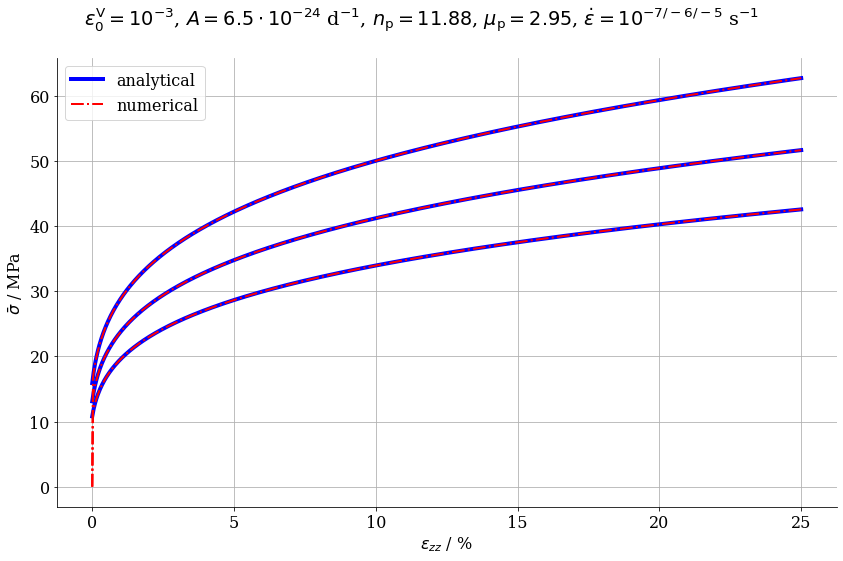

In [5]:
#HIDDEN
fig,ax = plt.subplots(figsize=(12,8))
eps_in = np.linspace(0,0.25,1000)
for doteps in [1e-7,1e-6,1e-5]:
    n_e, n_s = run_analyt(-doteps,1e-3,6.5e-24,11.88,2.95)
    if doteps==1e-7:
        ax.plot(eps_in*100, s_eff_analyt(doteps*86400, eps_in, 1e-3,6.5e-24,11.88,2.95),label='analytical',lw=4,color='b')
        ax.plot(-n_e*100, -n_s,ls='-.', label='numerical',color='r')
    else:
        ax.plot(eps_in*100, s_eff_analyt(doteps*86400, eps_in, 1e-3,6.5e-24,11.88,2.95),lw=4,color='b')
        ax.plot(-n_e*100, -n_s,ls='-.', color='r')
ax.set_xlabel('$\\epsilon_{zz}$ / %')
ax.set_ylabel('$\\bar{\\sigma}$ / MPa')
ax.grid('both')
ax.legend();
fig.suptitle('$\\epsilon_0^\\mathrm{V} = 10^{-3}$, $A = 6.5 \\cdot 10^{-24}$ d$^{-1}$, $n_\\mathrm{p} = 11.88$, $\\mu_\\mathrm{p} = 2.95$, $\\dot{\epsilon} = 10^{-7/-6/-5}$ s$^{-1}$')
fig.tight_layout();

## Analytical solution for constant effective stress (primary creep)

Under similar assumptions (only primary creep strain) we look at a case of constant effective stress. We depart from

$$
    (\epsilon_0^\text{V} + \epsilon)^{\mu_\text{p}}\, \text{d}\epsilon = A_\text{p} \left( \frac{\bar{\sigma}}{\sigma_\text{ref}} \right)^{n_\text{p}}\, \text{d}t
$$

Integration yields:

\begin{align}
    \int \limits_{\epsilon_0}^\epsilon (\epsilon_0^\text{V} + \tilde{\epsilon})^{\mu_\text{p}}\, \text{d}\tilde{\epsilon} &= \int \limits_{t_0}^t A_\text{p} \left( \frac{\bar{\sigma}}{\sigma_\text{ref}} \right)^{n_\text{p}}\, \text{d}\tilde{t}
    \\
    \frac{1}{\mu_\text{p}+1} \left[ (\epsilon_0^\text{V} + \epsilon)^{\mu_\text{p}+1} - (\epsilon_0^\text{V} + \epsilon_0)^{\mu_\text{p}+1} \right] &= A_\text{p} \left( \frac{\bar{\sigma}}{\sigma_\text{ref}} \right)^{n_\text{p}} (t - t_0)
\end{align}

Thus, we arrive at the following time-creep strain expression for a constant-stress interval:

$$
    \epsilon = \left[ A_\text{p} (\mu_\text{p} + 1) \left( \frac{\bar{\sigma}}{\sigma_\text{ref}} \right)^{n_\text{p}} (t-t_0) + (\epsilon_0^\text{V} + \epsilon_0)^{\mu_\text{p}+1} \right]^{\frac{1}{\mu_\text{p} + 1}} - \epsilon_0^\text{V}
$$


In [6]:
eps_analyt = lambda t, s_eff, t0, eps0, epsV0, A, n, m: np.power(A*(m+1)*np.power(s_eff,n)*(t - t0) + np.power(epsV0 + eps0,m+1),1/(m+1)) - epsV0

In [7]:
E = 1e5 #MPa
nu = 0.27
#
Ap = 6.5e-24 #1/d
npe = 11.88 #11.2, #quite sensitive
s0 = 1.0 #MPa
mup = 2.95 #quite sensitive
epsv0 = 0.0001 # very sensitive parameter!
#
As1 = 0.0
Q1 = 40e3
ns1 = 2.7
As2 = 0.0
Q2 = 65e3
ns2 = 6.8

In [8]:
#HIDDEN
def run_creep_IfG(t_discrete, sdiff=-25):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', 'src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStress('SZZ', {0: 0, 0.1:-16, 60: -16, 60.1: sdiff, 400: sdiff})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", 293.15)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
    return numerical

In [9]:
#HIDDEN
ndt = 200
times = np.append(np.linspace(0,10,ndt),
                  np.append(
                      np.linspace(11,60,ndt),
                      np.append(
                          np.linspace(60.1,70,ndt),
                          np.linspace(71,200,ndt)
                      )
                  )
                 )

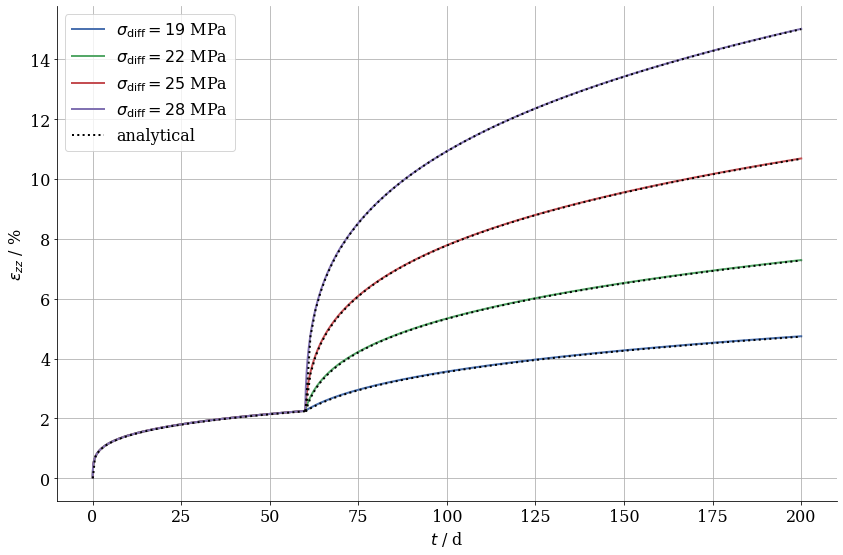

In [10]:
#HIDDEN
sigs = [-19,-22,-25,-28]
fig,ax = plt.subplots(figsize=(12,8))
for sig in sigs:
    ax.plot(times[1:],-run_creep_IfG(times,sig)[1:]*100,label='$\\sigma_\\mathrm{diff} = %i$ MPa' %(-sig))

t_an_1 = np.linspace(0.1,60,100)
ax.plot(t_an_1, eps_analyt(t_an_1, 16, 0.1, 0., 1.e-4, Ap, npe, mup)*100,color='black',ls=':',label='analytical')

t_an_2 = np.linspace(60.1,200,100)
for sig in sigs:
    ax.plot(t_an_2, eps_analyt(t_an_2, -sig, 60.1, eps_analyt(60, 16, 0.1, 0., 1.e-4, Ap, npe, mup), 1.e-4, Ap, npe, mup)*100,color='black',ls=':')
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\epsilon_{zz}$ / %')
ax.grid('both')
ax.legend();
fig.tight_layout();

## Multistage creep test

In [11]:
#HIDDEN
def run_creep_BMBF(t_discrete):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', 'src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStress('SZZ', {0: 0, 0.1: -20, 60: -20, 60.1: -15, 150: -15, 150.1: -20, 170:-20, 170.1: -18, 380: -18, 380.1: -20, 450: -20})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", 293.15)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
    return numerical

In [12]:
#HIDDEN
times = np.linspace(0,450,10000)

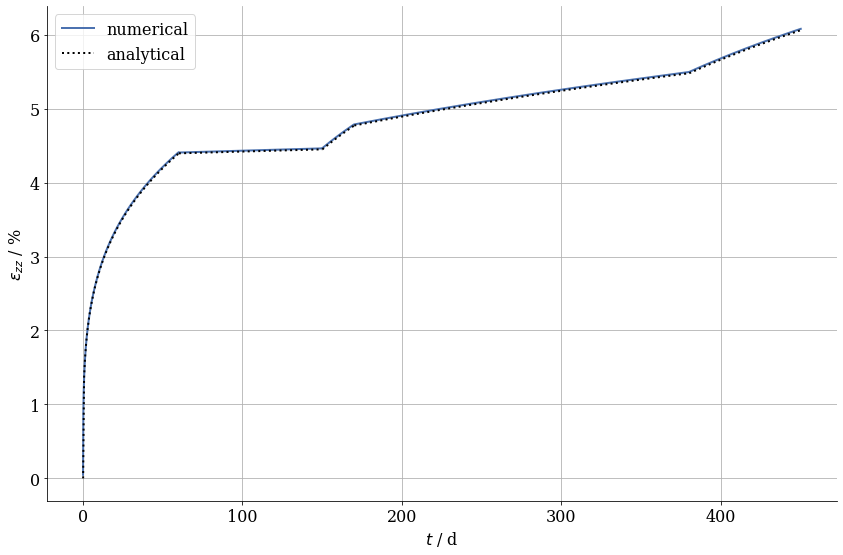

In [13]:
#HIDDEN
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(times[1:],-run_creep_BMBF(times)[1:]*100,label='numerical')
t_an_1 = np.linspace(0.1,60,100)
ax.plot(t_an_1, eps_analyt(t_an_1, 20, 0.1, 0., 1.e-4, Ap, npe, mup)*100,color='black',ls=':',label='analytical')
eps_end1 = eps_analyt(60.1, 20, 0.1, 0., 1.e-4, Ap, npe, mup)
#
t_an_2 = np.linspace(60.1,150,100)
ax.plot(t_an_2, eps_analyt(t_an_2, 15, 60.1, eps_end1, 1.e-4, Ap, npe, mup)*100,color='black',ls=':')
eps_end2 = eps_analyt(150.1, 15, 60.1, eps_end1, 1.e-4, Ap, npe, mup)
#
t_an_3 = np.linspace(150.1,170,100)
ax.plot(t_an_3, eps_analyt(t_an_3, 20, 150.1, eps_end2, 1.e-4, Ap, npe, mup)*100,color='black',ls=':')
eps_end3 = eps_analyt(170.1, 20, 150.1, eps_end2, 1.e-4, Ap, npe, mup)
#
t_an_4 = np.linspace(170.1,380,100)
ax.plot(t_an_4, eps_analyt(t_an_4, 18, 170.1, eps_end3, 1.e-4, Ap, npe, mup)*100,color='black',ls=':')
eps_end4 = eps_analyt(380.1, 18, 170.1, eps_end3, 1.e-4, Ap, npe, mup)
#
t_an_5 = np.linspace(380.1,450,100)
ax.plot(t_an_5, eps_analyt(t_an_5, 20, 380.1, eps_end4, 1.e-4, Ap, npe, mup)*100,color='black',ls=':')

ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\epsilon_{zz}$ / %')
ax.grid('both')
ax.legend()
fig.tight_layout();

## Rock Mech Rock Eng Test

In [14]:
E = 25e4 #MPa
nu = 0.27
#
Ap = 5.5e-40 #1/d
npe = 19.6
s0 = 1.0 #MPa
mup = 5.25
epsv0 = 0.0001 # very sensitive parameter!
#
As1 = 0.05
Q1 = 40e3
ns1 = 2.7
As2 = 0.02
Q2 = 65e3
ns2 = 6.8

In [15]:
#HIDDEN
def run_creep_Asse(T = 299, t1=45, t2 = 30, sdiff1=-25, sdiff2 = -25, s3 = -20.):
    t_discrete = np.linspace(0,t1+t2,1000)
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', 'src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', s3)
    m.setImposedStress('SYY', s3)
    m.setImposedStress('SZZ', {0: s3, 1:s3+sdiff1, t1: s3+sdiff1, t1+1: s3+sdiff2, t2+t1: s3+sdiff2})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", 333)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
    return t_discrete, numerical

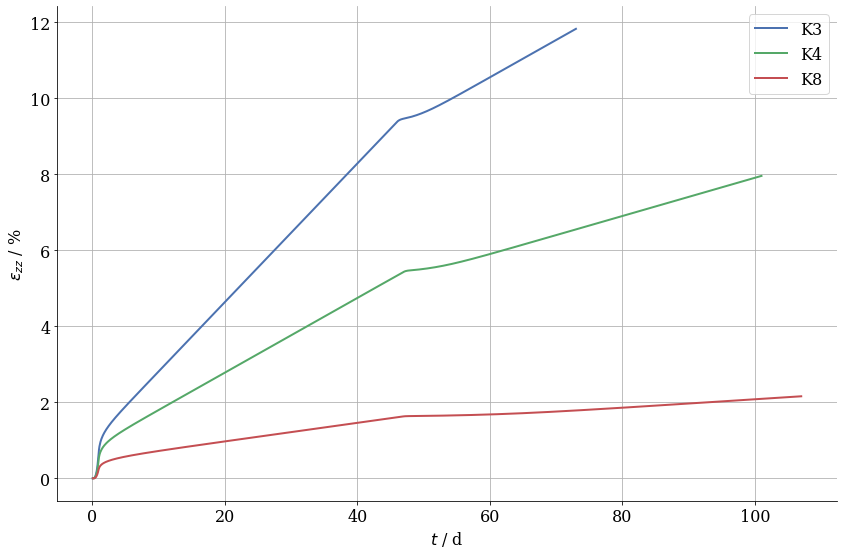

In [16]:
#HIDDEN
fig,ax = plt.subplots(figsize=(12,8))
t3, e3 = run_creep_Asse(T = 333, t1 = 46, t2 = 27, sdiff1 = -22, sdiff2 = -20, s3 = -20)
t4, e4 = run_creep_Asse(T = 333, t1 = 47, t2 = 54, sdiff1 = -20, sdiff2 = -18, s3 = -20)
t8, e8 = run_creep_Asse(T = 333, t1 = 47, t2 = 60, sdiff1 = -16, sdiff2 = -14, s3 = -20)
ax.plot(t3[1:],-e3[1:]*100, label= 'K3')
ax.plot(t4[1:],-e4[1:]*100, label= 'K4')
ax.plot(t8[1:],-e8[1:]*100, label= 'K8')
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\epsilon_{zz}$ / %')
ax.grid('both')
ax.legend()
fig.tight_layout();

In [17]:
#HIDDEN
def run_stress_effect_sim(t_discrete, sax, T):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(10)
    m.setBehaviour('generic', 'src/libBehaviour.so', 'GuentherSalzer')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStress('SZZ', {0:0, 1:sax})
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PrimaryPowerLawFactor', Ap)
    m.setMaterialProperty('PrimaryPowerLawExponent', npe)
    m.setMaterialProperty('SecondaryPowerLawFactor1', As1)
    m.setMaterialProperty('SecondaryPowerLawExponent1', ns1)
    m.setMaterialProperty('SecondaryActivationEnergy1', Q1)
    m.setMaterialProperty('SecondaryPowerLawFactor2', As2)
    m.setMaterialProperty('SecondaryPowerLawExponent2', ns2)
    m.setMaterialProperty('SecondaryActivationEnergy2', Q2)
    m.setMaterialProperty('HardeningExponent', mup)
    m.setMaterialProperty('InitialHardening', epsv0)
    m.setMaterialProperty('ReferenceStress', s0)
    m.setExternalStateVariable("Temperature", T)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    prev = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
        prev = np.append(prev,s.e0[2])
    return numerical, prev

In [18]:
#HIDDEN
#times = np.linspace(0,100,1000)
#sax = [0.1,0.5,1,2,3,4,5,10,15,25]
#temps = [20,50,100]
#cols = ['black','green','orange','red']
#fig,ax = plt.subplots(figsize=(12,8))
#for s in sax:
#    for i,T in enumerate(temps):
#        eps1, eps0 = run_stress_effect_sim(times,s,T+273.15)
#        dot_eps_av = (eps1[-1]-eps0[-1])/(times[-1] - times[-2])
#        if s == sax[0]:
#            ax.plot(s,dot_eps_av,label='$T$ = %i °C' %T, ls='', marker='d',color=cols[i])
#        else:
#            ax.plot(s,dot_eps_av, ls='', marker='d',color=cols[i])
#ax.set_xlabel('$\\sigma_\\mathrm{ax}$ / MPa')
#ax.set_ylabel('$\\dot{\\epsilon}_{zz}$ / d$^{-1}$')
#ax.set_xscale('log')
#ax.set_yscale('log')
#fig.tight_layout();
#fig.suptitle('Steady-state creep rate')
#ax.legend();